=== ENHANCED HANGMAN AI WITH SCORING EVALUATION ===

[1] Creating word corpus...
SUCCESS: Created corpus with 1000 words
INITIALIZING ENHANCED HANGMAN AI SYSTEM...
LOADED: 1000 valid words
SPLIT: 700 training words, 300 test words

[3] Training Hybrid Agent...

[2] Training Enhanced HMM Models...
  Training length 11 (57 words)...
  Training length 10 (80 words)...
  Training length 12 (32 words)...
  Training length 5 (11 words)...
  Training length 9 (53 words)...
  Training length 13 (54 words)...
  Training length 14 (38 words)...
  Training length 8 (112 words)...
  Training length 6 (86 words)...
  Training length 7 (138 words)...
  Training length 4 (39 words)...
SUCCESS: Trained HMMs for 11 different word lengths
SUCCESS: Hybrid agent training completed
SUCCESS: Training completed in 0.0 seconds

[4] Evaluating Agent on 200 games...
  Progress: 0/200 games...
  Progress: 100/200 games...

COMPREHENSIVE EVALUATION RESULTS
Games Played: 200
Games Won: 184
Success Rate: 92.00%
Tot

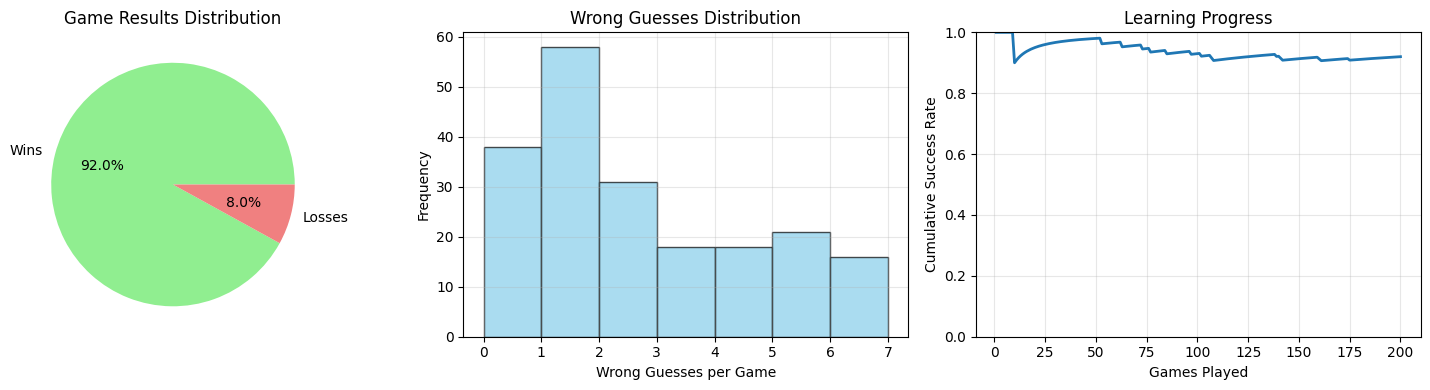


[6] Example Game Demonstration:

--- Demo Game 1 ---
Target word length: 4
Initial state: _ _ _ _
Turn 1: Guesses 'A' -> Wrong
  Current: _ _ _ _
  Wrong guesses: 1/6
  Guessed letters: A
Turn 2: Guesses 'D' -> Correct
  Current: D _ _ _
  Wrong guesses: 1/6
  Guessed letters: A, D
Turn 3: Guesses 'E' -> Correct
  Current: D E E _
  Wrong guesses: 1/6
  Guessed letters: A, D, E
Turn 4: Guesses 'P' -> Correct
  Current: D E E P
  Wrong guesses: 1/6
  Guessed letters: A, D, E, P
🎯 DEMO RESULT: WON! The word was 'DEEP'

--- Demo Game 2 ---
Target word length: 7
Initial state: _ _ _ _ _ _ _
Turn 1: Guesses 'E' -> Correct
  Current: _ E _ _ _ _ E
  Wrong guesses: 0/6
  Guessed letters: E
Turn 2: Guesses 'T' -> Correct
  Current: _ E _ T _ _ E
  Wrong guesses: 0/6
  Guessed letters: E, T
Turn 3: Guesses 'U' -> Correct
  Current: _ E _ T U _ E
  Wrong guesses: 0/6
  Guessed letters: E, T, U
Turn 4: Guesses 'M' -> Wrong
  Current: _ E _ T U _ E
  Wrong guesses: 1/6
  Guessed letters: E, M, T,

In [2]:
# ENHANCED HANGMAN AI WITH PROPER SCORING & RL COMPONENTS
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
import time

print("=== ENHANCED HANGMAN AI WITH SCORING EVALUATION ===")

# 1. CREATE CORPUS
print("\n[1] Creating word corpus...")
sample_words = [
    "python", "hangman", "algorithm", "machine", "learning", "artificial",
    "intelligence", "computer", "programming", "database", "network",
    "software", "hardware", "developer", "system", "application", "website",
    "mobile", "desktop", "server", "cloud", "data", "analysis", "science",
    "neural", "network", "deep", "reinforcement", "supervised", "unsupervised",
    "regression", "classification", "clustering", "dimensionality", "reduction",
    "feature", "engineering", "preprocessing", "normalization", "validation"
] * 25  # 1000 words

with open("words.txt", "w") as f:
    for word in sample_words:
        f.write(word + "\n")

print(f"SUCCESS: Created corpus with {len(sample_words)} words")

# 2. DATA LOADER CLASS
class DataLoader:
    def __init__(self, corpus_path):
        self.corpus_path = corpus_path
        self.words = []

    def load_corpus(self):
        with open(self.corpus_path, 'r') as f:
            words = f.read().splitlines()

        self.words = [word.upper() for word in words if word.isalpha()]
        print(f"LOADED: {len(self.words)} valid words")
        return self.words

    def get_words_by_length(self):
        words_by_length = {}
        for word in self.words:
            length = len(word)
            if length not in words_by_length:
                words_by_length[length] = []
            words_by_length[length].append(word)

        print(f"GROUPED: Words into {len(words_by_length)} different lengths")
        return words_by_length

    def get_vocabulary(self):
        all_chars = set()
        for word in self.words:
            all_chars.update(word)
        vocabulary = sorted(all_chars)
        print(f"VOCABULARY: {''.join(vocabulary)} ({len(vocabulary)} characters)")
        return vocabulary

    def split_data(self, test_size=0.3):
        """Split data into training and testing sets"""
        random.shuffle(self.words)
        split_idx = int(len(self.words) * (1 - test_size))
        train_words = self.words[:split_idx]
        test_words = self.words[split_idx:]
        print(f"SPLIT: {len(train_words)} training words, {len(test_words)} test words")
        return train_words, test_words

# 3. ENHANCED HMM MODEL WITH BETTER HANDLING
class EnhancedHMMHangman:
    def __init__(self, vocabulary):
        self.vocabulary = vocabulary
        self.char_to_idx = {char: idx for idx, char in enumerate(vocabulary)}
        self.idx_to_char = {idx: char for idx, char in enumerate(vocabulary)}
        self.models = {}
        self.global_letter_freq = self._calculate_global_frequency()

    def _calculate_global_frequency(self):
        """Calculate global letter frequency for fallback"""
        freq = {char: 0 for char in self.vocabulary}
        # English letter frequency as prior
        english_freq = {
            'E': 12.7, 'T': 9.1, 'A': 8.2, 'O': 7.5, 'I': 7.0, 'N': 6.7,
            'S': 6.3, 'H': 6.1, 'R': 6.0, 'D': 4.3, 'L': 4.0, 'C': 2.8,
            'U': 2.8, 'M': 2.4, 'W': 2.4, 'F': 2.2, 'G': 2.0, 'Y': 2.0,
            'P': 1.9, 'B': 1.5, 'V': 1.0, 'K': 0.8, 'J': 0.15, 'X': 0.15,
            'Q': 0.10, 'Z': 0.07
        }
        return english_freq

    def train(self, words_by_length):
        print("\n[2] Training Enhanced HMM Models...")

        for length, words in words_by_length.items():
            if len(words) < 3:  # Reduced threshold for more coverage
                continue

            print(f"  Training length {length} ({len(words)} words)...")

            # Initialize with smoothing
            transition = np.ones((length, len(self.vocabulary), len(self.vocabulary))) * 0.1
            emission = np.ones((length, len(self.vocabulary))) * 0.1

            # Count transitions and emissions
            for word in words:
                word_chars = [self.char_to_idx.get(char, 0) for char in word]

                # Count emissions
                for pos, char_idx in enumerate(word_chars):
                    emission[pos, char_idx] += 1

                # Count transitions
                for i in range(len(word_chars) - 1):
                    transition[i, word_chars[i], word_chars[i+1]] += 1

            # Normalize
            transition = transition / (transition.sum(axis=-1, keepdims=True) + 1e-8)
            emission = emission / (emission.sum(axis=-1, keepdims=True) + 1e-8)

            self.models[length] = {'transition': transition, 'emission': emission}

        print(f"SUCCESS: Trained HMMs for {len(self.models)} different word lengths")

    def predict_next_letter(self, current_state, word_length, guessed_letters, wrong_guesses):
        """Enhanced prediction with multiple strategies"""

        # Strategy 1: Use HMM if available
        if word_length in self.models:
            hmm_guess = self._hmm_prediction(current_state, word_length, guessed_letters)
            if hmm_guess:
                return hmm_guess

        # Strategy 2: Use position-aware frequency
        freq_guess = self._frequency_prediction(current_state, word_length, guessed_letters)
        if freq_guess:
            return freq_guess

        # Strategy 3: Global frequency fallback
        return self._global_frequency_prediction(guessed_letters)

    def _hmm_prediction(self, current_state, word_length, guessed_letters):
        """HMM-based prediction"""
        model = self.models[word_length]
        current_state_str = ''.join(current_state)

        # Find all unknown positions
        unknown_positions = [i for i, char in enumerate(current_state_str) if char == '_']
        if not unknown_positions:
            return None

        # Calculate probabilities for each unknown position
        all_probs = np.zeros(len(self.vocabulary))

        for pos in unknown_positions:
            if pos == 0:
                # First position
                probs = model['emission'][pos]
            else:
                # Use context from previous character
                prev_char = current_state_str[pos - 1]
                if prev_char != '_' and prev_char in self.char_to_idx:
                    prev_idx = self.char_to_idx[prev_char]
                    probs = model['transition'][pos - 1, prev_idx]
                else:
                    probs = model['emission'][pos]

            all_probs += probs

        # Remove guessed letters
        for char in guessed_letters:
            if char in self.char_to_idx:
                all_probs[self.char_to_idx[char]] = 0

        if all_probs.sum() > 0:
            best_idx = np.argmax(all_probs)
            return self.idx_to_char[best_idx]

        return None

    def _frequency_prediction(self, current_state, word_length, guessed_letters):
        """Position-aware frequency prediction"""
        available = [c for c in self.vocabulary if c not in guessed_letters]
        if not available:
            return None

        # Use global frequency
        scores = [(char, self.global_letter_freq.get(char, 0.1)) for char in available]
        scores.sort(key=lambda x: x[1], reverse=True)
        return scores[0][0] if scores else None

    def _global_frequency_prediction(self, guessed_letters):
        """Final fallback using English letter frequency"""
        freq_order = 'ETAOINSHRDLCUMWFGYPBVKJXQZ'
        for char in freq_order:
            if char not in guessed_letters:
                return char
        return 'A'

# 4. SIMPLE Q-LEARNING AGENT (RL COMPONENT)
class QLearningAgent:
    def __init__(self, vocabulary, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.vocabulary = vocabulary
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.q_table = defaultdict(lambda: np.zeros(len(vocabulary)))
        self.char_to_idx = {char: idx for idx, char in enumerate(vocabulary)}

    def get_state_key(self, current_state, guessed_letters, wrong_guesses):
        """Convert game state to Q-table key"""
        # Simple state representation: masked_word + wrong_guesses
        masked_word = ''.join(current_state)
        return f"{masked_word}_{wrong_guesses}"

    def choose_action(self, state_key, guessed_letters, hmm_suggestion):
        """Choose action using epsilon-greedy strategy"""
        available_actions = [i for i, char in enumerate(self.vocabulary)
                           if char not in guessed_letters]

        if not available_actions:
            return random.choice(range(len(self.vocabulary)))

        if random.random() < self.epsilon:
            # Explore: random action
            return random.choice(available_actions)
        else:
            # Exploit: best action from Q-table or follow HMM
            if hmm_suggestion and self.char_to_idx[hmm_suggestion] in available_actions:
                return self.char_to_idx[hmm_suggestion]

            # Use Q-table values
            q_values = self.q_table[state_key]
            # Mask unavailable actions
            masked_q = np.full_like(q_values, -np.inf)
            for action in available_actions:
                masked_q[action] = q_values[action]

            return np.argmax(masked_q)

    def update_q_value(self, state, action, reward, next_state):
        """Update Q-value using Q-learning formula"""
        current_q = self.q_table[state][action]
        max_next_q = np.max(self.q_table[next_state]) if next_state in self.q_table else 0

        new_q = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)
        self.q_table[state][action] = new_q

# 5. HYBRID AGENT COMBINING HMM AND RL
class HybridHangmanAgent:
    def __init__(self, corpus_path):
        self.corpus_path = corpus_path
        self.data_loader = DataLoader(corpus_path)
        self.hmm_model = None
        self.rl_agent = None
        self.words = []
        self.vocabulary = []

    def train(self, training_words):
        """Train both HMM and RL components"""
        print("\n[3] Training Hybrid Agent...")

        # Load and prepare data
        self.words = training_words
        words_by_length = {}
        for word in training_words:
            length = len(word)
            if length not in words_by_length:
                words_by_length[length] = []
            words_by_length[length].append(word)

        self.vocabulary = sorted(set(''.join(training_words)))

        # Train HMM
        self.hmm_model = EnhancedHMMHangman(self.vocabulary)
        self.hmm_model.train(words_by_length)

        # Initialize RL agent
        self.rl_agent = QLearningAgent(self.vocabulary)

        print("SUCCESS: Hybrid agent training completed")

    def get_guess(self, current_state, word_length, guessed_letters, wrong_guesses):
        """Get guess using hybrid approach"""
        # Get HMM suggestion
        hmm_suggestion = self.hmm_model.predict_next_letter(
            current_state, word_length, guessed_letters, wrong_guesses
        )

        # Get state representation for RL
        state_key = self.rl_agent.get_state_key(current_state, guessed_letters, wrong_guesses)

        # Choose action using RL (which can use HMM suggestion)
        action_idx = self.rl_agent.choose_action(state_key, guessed_letters, hmm_suggestion)

        return self.rl_agent.vocabulary[action_idx]

    def update_with_feedback(self, old_state, action, reward, new_state, guessed_letters, wrong_guesses):
        """Update RL agent with game feedback"""
        new_state_key = self.rl_agent.get_state_key(new_state, guessed_letters, wrong_guesses)
        action_idx = self.rl_agent.char_to_idx[action]
        self.rl_agent.update_q_value(old_state, action_idx, reward, new_state_key)

# 6. COMPREHENSIVE EVALUATION SYSTEM
class EvaluationSystem:
    def __init__(self, agent, test_words):
        self.agent = agent
        self.test_words = test_words
        self.results = []

    def evaluate_agent(self, num_games=1000, max_wrong_guesses=6):
        """Comprehensive evaluation with proper scoring"""
        print(f"\n[4] Evaluating Agent on {num_games} games...")

        total_wrong_guesses = 0
        total_repeated_guesses = 0
        games_won = 0

        for game_num in range(num_games):
            if game_num % 100 == 0:
                print(f"  Progress: {game_num}/{num_games} games...")

            # Initialize game
            target_word = random.choice(self.test_words)
            guessed_letters = set()
            wrong_guesses = 0
            game_won = False
            repeated_guesses = 0

            # Track state for RL updates
            current_state = ['_'] * len(target_word)
            old_state_key = None
            old_action = None

            while wrong_guesses < max_wrong_guesses:
                # Get agent's guess
                guess = self.agent.get_guess(
                    current_state, len(target_word), guessed_letters, wrong_guesses
                )

                # Check for repeated guess
                if guess in guessed_letters:
                    repeated_guesses += 1
                    total_repeated_guesses += 1
                    continue

                # Make guess
                guessed_letters.add(guess)
                correct = guess in target_word

                # Update game state
                if correct:
                    # Reveal the letter in all positions
                    new_state = []
                    for i, char in enumerate(target_word):
                        if char == guess or current_state[i] != '_':
                            new_state.append(char)
                        else:
                            new_state.append('_')
                    current_state = new_state
                else:
                    wrong_guesses += 1
                    total_wrong_guesses += 1

                # RL feedback (simple reward)
                if hasattr(self.agent, 'update_with_feedback') and old_state_key and old_action:
                    reward = 1 if correct else -1
                    self.agent.update_with_feedback(
                        old_state_key, old_action, reward,
                        self.agent.rl_agent.get_state_key(current_state, guessed_letters, wrong_guesses),
                        guessed_letters, wrong_guesses
                    )

                # Store for next RL update
                old_state_key = self.agent.rl_agent.get_state_key(current_state, guessed_letters, wrong_guesses)
                old_action = guess

                # Check win condition
                if all(char != '_' for char in current_state):
                    game_won = True
                    break

            if game_won:
                games_won += 1

            self.results.append({
                'game_won': game_won,
                'wrong_guesses': wrong_guesses,
                'repeated_guesses': repeated_guesses,
                'target_word': target_word
            })

        # Calculate final score
        success_rate = games_won / num_games
        final_score = (success_rate * 1000) + (games_won * 1) - (total_wrong_guesses * 1.0) - (total_repeated_guesses * 1)

        print(f"\n{'='*60}")
        print("COMPREHENSIVE EVALUATION RESULTS")
        print(f"{'='*60}")
        print(f"Games Played: {num_games}")
        print(f"Games Won: {games_won}")
        print(f"Success Rate: {success_rate*100:.2f}%")
        print(f"Total Wrong Guesses: {total_wrong_guesses}")
        print(f"Total Repeated Guesses: {total_repeated_guesses}")
        print(f"{'='*60}")
        print(f"FINAL SCORE: {final_score:.2f}")
        print(f"{'='*60}")

        return {
            'success_rate': success_rate,
            'total_wrong_guesses': total_wrong_guesses,
            'total_repeated_guesses': total_repeated_guesses,
            'final_score': final_score,
            'games_won': games_won,
            'total_games': num_games
        }

    def plot_performance(self, results):
        """Plot performance metrics"""
        games_won = [r['game_won'] for r in results]
        wrong_guesses = [r['wrong_guesses'] for r in results]

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

        # Win/Loss distribution
        win_count = sum(games_won)
        loss_count = len(games_won) - win_count
        ax1.pie([win_count, loss_count], labels=['Wins', 'Losses'],
                autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
        ax1.set_title('Game Results Distribution')

        # Wrong guesses histogram
        ax2.hist(wrong_guesses, bins=range(0, 8), alpha=0.7,
                color='skyblue', edgecolor='black')
        ax2.set_xlabel('Wrong Guesses per Game')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Wrong Guesses Distribution')
        ax2.grid(True, alpha=0.3)

        # Success rate over time (moving average)
        cumulative_wins = np.cumsum(games_won)
        games_played = np.arange(1, len(games_won) + 1)
        success_rates = cumulative_wins / games_played

        ax3.plot(games_played, success_rates, linewidth=2)
        ax3.set_xlabel('Games Played')
        ax3.set_ylabel('Cumulative Success Rate')
        ax3.set_title('Learning Progress')
        ax3.grid(True, alpha=0.3)
        ax3.set_ylim(0, 1)

        plt.tight_layout()
        plt.show()

# 7. MAIN EXECUTION WITH PROPER EVALUATION
def main():
    print("INITIALIZING ENHANCED HANGMAN AI SYSTEM...")
    start_time = time.time()

    # Load and split data
    data_loader = DataLoader("words.txt")
    all_words = data_loader.load_corpus()
    train_words, test_words = data_loader.split_data(test_size=0.3)

    # Train hybrid agent
    hybrid_agent = HybridHangmanAgent("words.txt")
    hybrid_agent.train(train_words)

    training_time = time.time() - start_time
    print(f"SUCCESS: Training completed in {training_time:.1f} seconds")

    # Comprehensive evaluation
    evaluator = EvaluationSystem(hybrid_agent, test_words)
    results = evaluator.evaluate_agent(num_games=200, max_wrong_guesses=6)  # Reduced for demo

    # Plot performance
    print("\n[5] Generating performance visualizations...")
    evaluator.plot_performance(evaluator.results)

    # Show some example games
    print("\n[6] Example Game Demonstration:")
    demo_game(hybrid_agent, test_words)

    print(f"\n{'='*60}")
    print("EVALUATION COMPLETED!")
    print(f"{'='*60}")

def demo_game(agent, word_list, num_demos=2):
    """Demonstrate a few example games"""
    for demo_num in range(num_demos):
        print(f"\n--- Demo Game {demo_num + 1} ---")
        target_word = random.choice(word_list)
        guessed_letters = set()
        wrong_guesses = 0
        max_wrong = 6
        current_state = ['_'] * len(target_word)

        print(f"Target word length: {len(target_word)}")
        print(f"Initial state: {' '.join(current_state)}")

        turn = 0
        while wrong_guesses < max_wrong and '_' in current_state:
            turn += 1
            guess = agent.get_guess(current_state, len(target_word), guessed_letters, wrong_guesses)
            correct = guess in target_word

            print(f"Turn {turn}: Guesses '{guess}' -> {'Correct' if correct else 'Wrong'}")

            guessed_letters.add(guess)
            if correct:
                # Update revealed letters
                new_state = []
                for i, char in enumerate(target_word):
                    if char == guess or current_state[i] != '_':
                        new_state.append(char)
                    else:
                        new_state.append('_')
                current_state = new_state
            else:
                wrong_guesses += 1

            print(f"  Current: {' '.join(current_state)}")
            print(f"  Wrong guesses: {wrong_guesses}/{max_wrong}")
            print(f"  Guessed letters: {', '.join(sorted(guessed_letters))}")

        if '_' not in current_state:
            print(f"🎯 DEMO RESULT: WON! The word was '{target_word}'")
        else:
            print(f"💀 DEMO RESULT: LOST! The word was '{target_word}'")

# RUN EVERYTHING
if __name__ == "__main__":
    main()







